In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import json
import warnings
import os
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import (
    train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import joblib

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully")
print("Ready to build SVM classification pipeline for NCA features")

Libraries imported successfully
Ready to build SVM classification pipeline for NCA features


## Step 1: Data Preparation

Load the NCA features and prepare the dataset for training.

In [2]:
print("="*70)
print("STEP 1: DATA PREPARATION")
print("="*70)

# Configuration
USE_NCA_9 = True   # Set to True to use features_nca_9.csv
USE_NCA_10 = False # Set to False (overridden if USE_NCA_9 is True)

if USE_NCA_9 and os.path.exists('../data/features_nca_9.csv'):
    features_file = '../data/features_nca_9.csv'
    print(f"Using 9-component NCA features: {features_file}")
elif USE_NCA_10 and os.path.exists('../data/features_nca_10.csv'):
    features_file = '../data/features_nca_10.csv'
    print(f"Using 10-component NCA features: {features_file}")
elif os.path.exists('../data/features_nca_2.csv'):
    features_file = '../data/features_nca_2.csv'
    print(f"Using 2-component NCA features: {features_file}")
else:
    raise FileNotFoundError("No valid NCA feature files found.")

# Load the features dataset
df = pd.read_csv(features_file)

print(f"\nLoaded dataset: {features_file}")
print(f"Dataset shape: {df.shape}")

# Extract Features (columns starting with 'nca')
feature_cols = [c for c in df.columns if c.startswith('nca')]
X = df[feature_cols].values
feature_names = feature_cols

# Extract Targets (robust label extraction)
if 'label' in df.columns:
    y_raw = df['label'].values
    print("Using 'label' column for targets")
elif 'label_code' in df.columns:
    y_raw = df['label_code'].values
    print("Using 'label_code' column for targets")
else:
    # Fallback to filename extraction
    print("Extracting labels from filenames...")
    y_raw = df['filename'].astype(str).str.extract(r'(?i)(h\d+)')[0].str.upper().fillna('UNKNOWN').values

print(f"Number of species: {len(np.unique(y_raw))}")
print(f"\nSpecies distribution:")
print(pd.Series(y_raw).value_counts())

# Handle any NaN values
if np.isnan(X).any():
    print(f"\nWarning: Found {np.isnan(X).sum()} NaN values. Filling with column means.")
    col_mean = np.nanmean(X, axis=0)
    inds = np.where(np.isnan(X))
    X[inds] = np.take(col_mean, inds[1])

print(f"\nFeature matrix shape: {X.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"Number of samples: {len(y_raw)}")

# Encode species labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_raw)
species_names = le.classes_

print(f"\nEncoded labels: {dict(zip(species_names, range(len(species_names))))}")

# Split data into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTrain set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")
print(f"Train set distribution:")
train_dist = pd.Series(y_train).value_counts().sort_index()
for idx, count in train_dist.items():
    print(f"  {species_names[idx]}: {count}")

# Standardize features (fit on train, transform both)
scaler_svm = StandardScaler()
X_train_scaled = scaler_svm.fit_transform(X_train)
X_test_scaled = scaler_svm.transform(X_test)

print("\n✓ Features standardized (zero mean, unit variance)")
print("✓ Data preparation complete")

STEP 1: DATA PREPARATION
Using 10-component NCA features: ../data/features_nca_10.csv

Loaded dataset: ../data/features_nca_10.csv
Dataset shape: (3277, 12)
Using 'label' column for targets
Number of species: 10

Species distribution:
H4     344
H2     344
H7     344
H6     344
H5     343
H1     343
H3     343
H8     328
H9     286
H10    258
Name: count, dtype: int64

Feature matrix shape: (3277, 10)
Number of features: 10
Number of samples: 3277

Encoded labels: {'H1': 0, 'H10': 1, 'H2': 2, 'H3': 3, 'H4': 4, 'H5': 5, 'H6': 6, 'H7': 7, 'H8': 8, 'H9': 9}

Train set size: 2621 samples
Test set size: 656 samples
Train set distribution:
  H1: 274
  H10: 207
  H2: 275
  H3: 274
  H4: 275
  H5: 274
  H6: 275
  H7: 275
  H8: 263
  H9: 229

✓ Features standardized (zero mean, unit variance)
✓ Data preparation complete


## Step 2: Baseline SVM Models

Train baseline SVM models with different kernels (linear, RBF, polynomial) to compare performance.


STEP 2: BASELINE SVM MODELS

Training SVM with LINEAR kernel...
  Accuracy:  0.3628
  Precision: 0.3693
  Recall:    0.3628
  F1-Score:  0.3605
  Time:      0.28s

Training SVM with RBF kernel...
  Accuracy:  0.7561
  Precision: 0.7574
  Recall:    0.7561
  F1-Score:  0.7551
  Time:      0.18s

Training SVM with POLY kernel...
  Accuracy:  0.6631
  Precision: 0.6943
  Recall:    0.6631
  F1-Score:  0.6687
  Time:      0.16s

----------------------------------------------------------------------
BASELINE MODEL COMPARISON
----------------------------------------------------------------------


,Kernel,Accuracy,Precision,Recall,F1-Score,Time (s)
0,linear,0.3628,0.3693,0.3628,0.3605,0.2775
1,rbf,0.7561,0.7574,0.7561,0.7551,0.1848
2,poly,0.6631,0.6943,0.6631,0.6687,0.1598


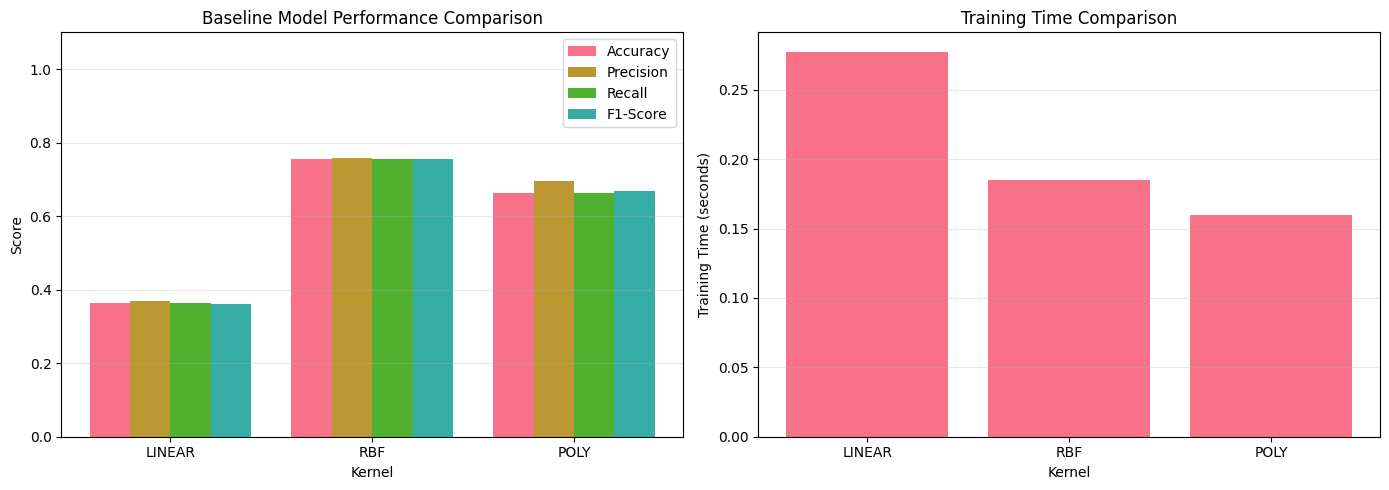


✓ Best baseline kernel: RBF (Accuracy: 0.7561)


In [3]:
print("\n" + "="*70)
print("STEP 2: BASELINE SVM MODELS")
print("="*70)

# Test different SVM kernels
kernels = ['linear', 'rbf', 'poly']
baseline_results = {}

for kernel in kernels:
    print(f"\nTraining SVM with {kernel.upper()} kernel...")
    start_time = time.time()
    
    # Create and train SVM
    svm = SVC(kernel=kernel, random_state=42, gamma='scale')
    svm.fit(X_train_scaled, y_train)
    
    # Predict on test set
    y_pred = svm.predict(X_test_scaled)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    training_time = time.time() - start_time
    
    # Store results
    baseline_results[kernel] = {
        'model': svm,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'training_time': training_time,
        'predictions': y_pred
    }
    
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  Time:      {training_time:.2f}s")

# Compare baseline models
print("\n" + "-"*70)
print("BASELINE MODEL COMPARISON")
print("-"*70)

comparison_df = pd.DataFrame({
    'Kernel': list(baseline_results.keys()),
    'Accuracy': [baseline_results[k]['accuracy'] for k in baseline_results.keys()],
    'Precision': [baseline_results[k]['precision'] for k in baseline_results.keys()],
    'Recall': [baseline_results[k]['recall'] for k in baseline_results.keys()],
    'F1-Score': [baseline_results[k]['f1'] for k in baseline_results.keys()],
    'Time (s)': [baseline_results[k]['training_time'] for k in baseline_results.keys()]
})

display(comparison_df.round(4))

# Visualize baseline comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(kernels))
width = 0.2

for i, metric in enumerate(metrics):
    axes[0].bar(x + i*width, comparison_df[metric], width, label=metric)

axes[0].set_xlabel('Kernel')
axes[0].set_ylabel('Score')
axes[0].set_title('Baseline Model Performance Comparison')
axes[0].set_xticks(x + width * 1.5)
axes[0].set_xticklabels([k.upper() for k in kernels])
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1.1])

# Plot training time
axes[1].bar(kernels, comparison_df['Time (s)'])
axes[1].set_xlabel('Kernel')
axes[1].set_ylabel('Training Time (seconds)')
axes[1].set_title('Training Time Comparison')
axes[1].set_xticklabels([k.upper() for k in kernels])
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Find best baseline model
best_kernel = max(baseline_results.keys(), key=lambda k: baseline_results[k]['accuracy'])
print(f"\n✓ Best baseline kernel: {best_kernel.upper()} (Accuracy: {baseline_results[best_kernel]['accuracy']:.4f})")

## Step 3: Hyperparameter Tuning

Perform grid search with cross-validation to find optimal hyperparameters.

In [4]:
print("\n" + "="*70)
print("STEP 3: HYPERPARAMETER TUNING")
print("="*70)

# Define parameter grid for RBF and Linear kernels
param_grid = [
    {
        'kernel': ['rbf'],
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
    },
    {
        'kernel': ['linear'],
        'C': [0.1, 1, 10, 100]
    },
    {
        'kernel': ['poly'],
        'C': [0.1, 1, 10],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto']
    }
]

print("\nParameter grid defined:")
print(f"  RBF: C={[0.1, 1, 10, 100]}, gamma={['scale', 'auto', 0.001, 0.01, 0.1]}")
print(f"  Linear: C={[0.1, 1, 10, 100]}")
print(f"  Poly: C={[0.1, 1, 10]}, degree={[2, 3, 4]}, gamma={['scale', 'auto']}")

# Perform grid search with cross-validation
print("\nPerforming GridSearchCV (5-fold cross-validation)...")
print("This may take a few minutes...")

start_time = time.time()

grid_search = GridSearchCV(
    SVC(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

grid_time = time.time() - start_time

print(f"\n✓ Grid search completed in {grid_time:.2f}s")
print(f"\nBest parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation score: {grid_search.best_score_:.4f}")

# Get the best model
best_svm = grid_search.best_estimator_

# Test on held-out test set
y_pred_best = best_svm.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred_best)

print(f"Test set accuracy: {test_accuracy:.4f}")

# Show top 10 parameter combinations
print("\nTop 10 parameter combinations:")
results_df = pd.DataFrame(grid_search.cv_results_)
top_results = results_df.nsmallest(10, 'rank_test_score')[
    ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
]
display(top_results)


STEP 3: HYPERPARAMETER TUNING

Parameter grid defined:
  RBF: C=[0.1, 1, 10, 100], gamma=['scale', 'auto', 0.001, 0.01, 0.1]
  Linear: C=[0.1, 1, 10, 100]
  Poly: C=[0.1, 1, 10], degree=[2, 3, 4], gamma=['scale', 'auto']

Performing GridSearchCV (5-fold cross-validation)...
This may take a few minutes...
Fitting 5 folds for each of 42 candidates, totalling 210 fits


KeyboardInterrupt: 

## Step 4: Cross-Validation Analysis

Perform detailed cross-validation to assess model stability and generalization.


STEP 4: CROSS-VALIDATION ANALYSIS

Performing 10-fold stratified cross-validation...

Cross-validation scores (10 folds):
  Fold  1: 0.7757
  Fold  2: 0.8092
  Fold  3: 0.7672
  Fold  4: 0.8053
  Fold  5: 0.7786
  Fold  6: 0.7977
  Fold  7: 0.8015
  Fold  8: 0.7595
  Fold  9: 0.7634
  Fold 10: 0.8130

Cross-validation summary:
  Mean accuracy: 0.7871 (+/- 0.0386)
  Median accuracy: 0.7882
  Min accuracy: 0.7595
  Max accuracy: 0.8130


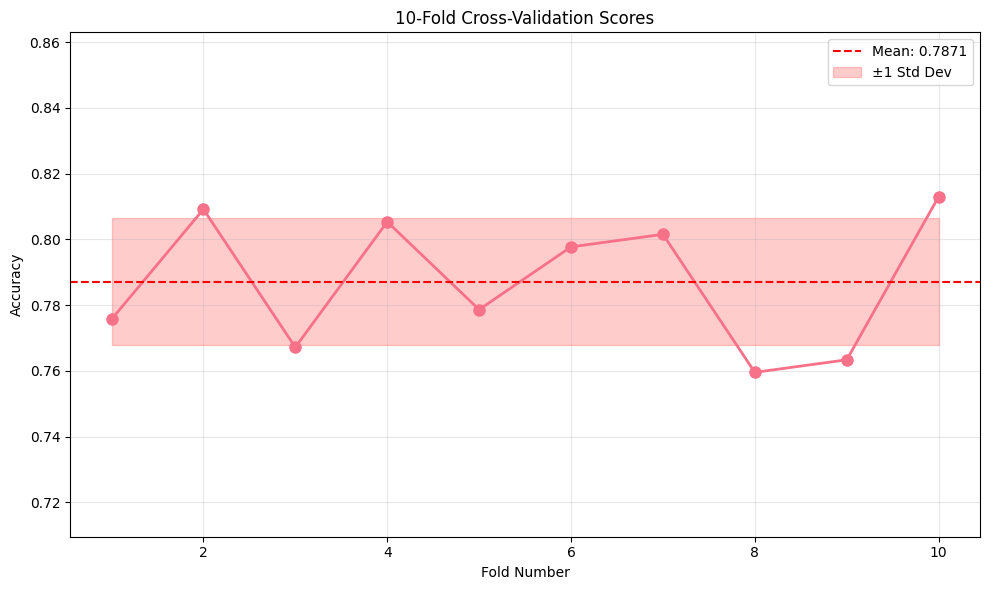


✓ Cross-validation analysis complete


In [ ]:
print("\n" + "="*70)
print("STEP 4: CROSS-VALIDATION ANALYSIS")
print("="*70)

# Perform stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

print("\nPerforming 10-fold stratified cross-validation...")
cv_scores = cross_val_score(best_svm, X_train_scaled, y_train, cv=skf, scoring='accuracy', n_jobs=-1)

print(f"\nCross-validation scores (10 folds):")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i:2d}: {score:.4f}")

print(f"\nCross-validation summary:")
print(f"  Mean accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"  Median accuracy: {np.median(cv_scores):.4f}")
print(f"  Min accuracy: {cv_scores.min():.4f}")
print(f"  Max accuracy: {cv_scores.max():.4f}")

# Visualize cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), cv_scores, 'o-', linewidth=2, markersize=8)
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.fill_between(range(1, 11), 
                 cv_scores.mean() - cv_scores.std(), 
                 cv_scores.mean() + cv_scores.std(), 
                 alpha=0.2, color='r', label=f'±1 Std Dev')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('10-Fold Cross-Validation Scores')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([max(0, cv_scores.min() - 0.05), min(1, cv_scores.max() + 0.05)])
plt.tight_layout()
plt.show()

print("\n✓ Cross-validation analysis complete")

## Step 5: Performance Evaluation

Comprehensive evaluation with confusion matrix, classification report, and per-class metrics.


STEP 5: PERFORMANCE EVALUATION

Overall Performance Metrics:
  Accuracy:  0.8018
  Precision: 0.8024
  Recall:    0.8018
  F1-Score:  0.8004

----------------------------------------------------------------------
CLASSIFICATION REPORT (Per-Class Metrics)
----------------------------------------------------------------------
              precision    recall  f1-score   support

          H1     0.9444    0.9855    0.9645        69
         H10     0.6792    0.7059    0.6923        51
          H2     0.8676    0.8551    0.8613        69
          H3     0.8025    0.9420    0.8667        69
          H4     0.8571    0.8696    0.8633        69
          H5     0.8571    0.7826    0.8182        69
          H6     0.7302    0.6667    0.6970        69
          H7     0.6883    0.7681    0.7260        69
          H8     0.7895    0.6923    0.7377        65
          H9     0.7692    0.7018    0.7339        57

    accuracy                         0.8018       656
   macro avg     0.7985

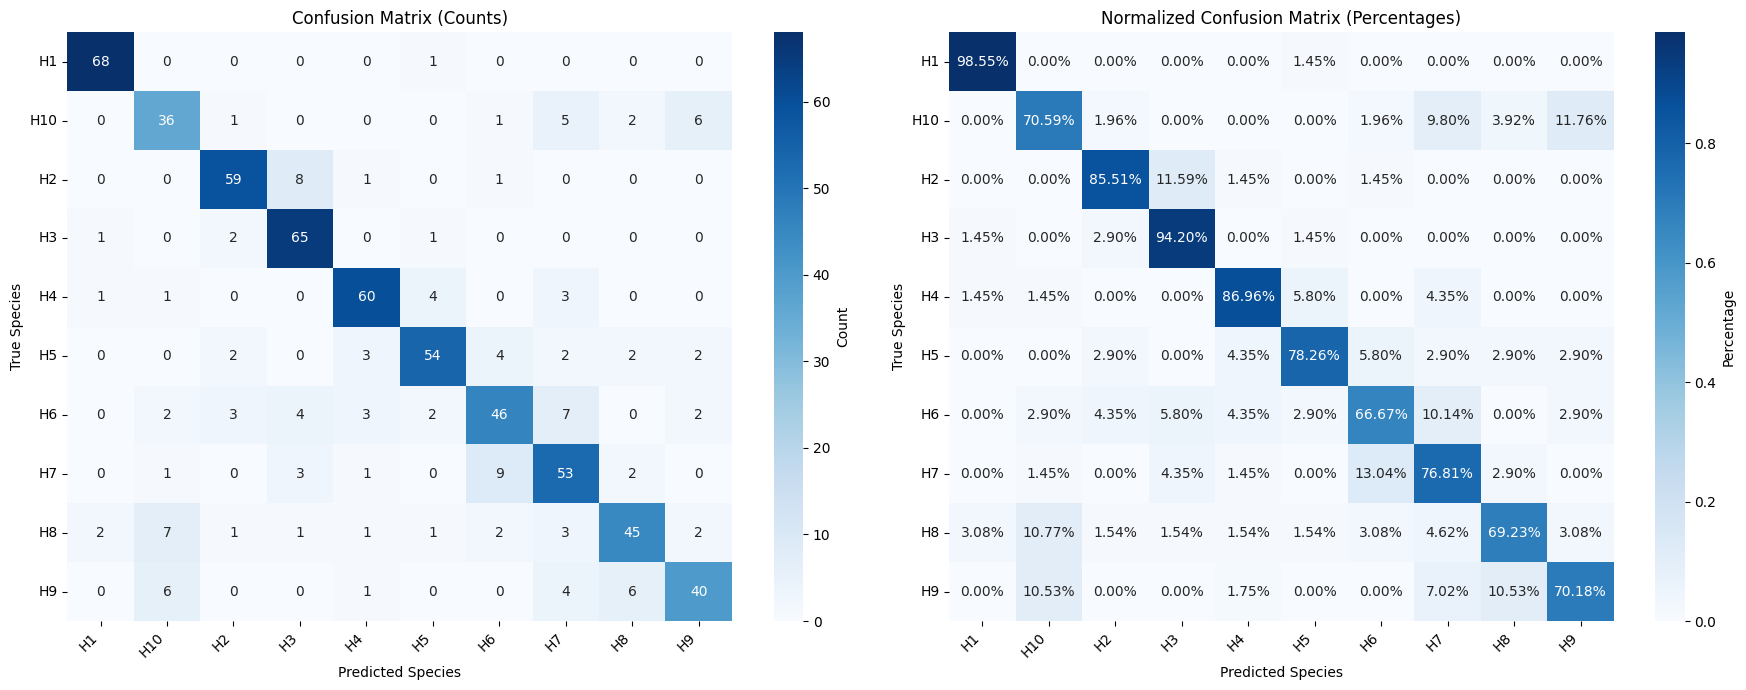


Per-Class Accuracy:
  H1: 0.9855 (68/69)
  H10: 0.7059 (36/51)
  H2: 0.8551 (59/69)
  H3: 0.9420 (65/69)
  H4: 0.8696 (60/69)
  H5: 0.7826 (54/69)
  H6: 0.6667 (46/69)
  H7: 0.7681 (53/69)
  H8: 0.6923 (45/65)
  H9: 0.7018 (40/57)

✓ Performance evaluation complete


In [ ]:
print("\n" + "="*70)
print("STEP 5: PERFORMANCE EVALUATION")
print("="*70)

# Get predictions on test set
y_pred_final = best_svm.predict(X_test_scaled)

# Calculate comprehensive metrics
accuracy = accuracy_score(y_test, y_pred_final)
precision = precision_score(y_test, y_pred_final, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred_final, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred_final, average='weighted', zero_division=0)

print("\nOverall Performance Metrics:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")

# Detailed classification report
print("\n" + "-"*70)
print("CLASSIFICATION REPORT (Per-Class Metrics)")
print("-"*70)
print(classification_report(y_test, y_pred_final, target_names=species_names, digits=4, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_final)

print("\n" + "-"*70)
print("CONFUSION MATRIX")
print("-"*70)

# Visualize confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Count matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=species_names, yticklabels=species_names,
            cbar_kws={'label': 'Count'}, ax=axes[0])
axes[0].set_xlabel('Predicted Species')
axes[0].set_ylabel('True Species')
axes[0].set_title('Confusion Matrix (Counts)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

# Normalized confusion matrix (percentages)
# Add small epsilon to avoid division by zero if a class has no samples in test set (though stratify helps)
cm_sum = cm.sum(axis=1)[:, np.newaxis]
cm_normalized = cm.astype('float') / (cm_sum + 1e-9)

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=species_names, yticklabels=species_names,
            cbar_kws={'label': 'Percentage'}, ax=axes[1])
axes[1].set_xlabel('Predicted Species')
axes[1].set_ylabel('True Species')
axes[1].set_title('Normalized Confusion Matrix (Percentages)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

# Per-class accuracy
print("\nPer-Class Accuracy:")
for i, species in enumerate(species_names):
    total = cm[i, :].sum()
    class_accuracy = cm[i, i] / total if total > 0 else 0
    print(f"  {species}: {class_accuracy:.4f} ({cm[i, i]}/{total})")

print("\n✓ Performance evaluation complete")

## Step 6: Feature Importance Analysis

Analyze which features contribute most to classification (available for linear kernel).

In [ ]:
print("\n" + "="*70)
print("STEP 6: FEATURE IMPORTANCE ANALYSIS")
print("="*70)

if best_svm.kernel == 'linear':
    print("\nAnalyzing feature importance for linear SVM...")
    
    # Get feature weights from linear SVM
    # For multi-class, we have one weight vector per class
    coef = best_svm.coef_
    
    print(f"Coefficient matrix shape: {coef.shape}")
    print(f"({coef.shape[0]} classes × {coef.shape[1]} features)")
    
    # Calculate mean absolute coefficient across all classes
    mean_abs_coef = np.abs(coef).mean(axis=0)
    
    # Create feature importance dataframe
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': mean_abs_coef
    }).sort_values('importance', ascending=False)
    
    print("\nTop 20 Most Important Features:")
    display(feature_importance.head(20))
    
    # Visualize top 20 features
    plt.figure(figsize=(12, 8))
    top_20 = feature_importance.head(20)
    plt.barh(range(len(top_20)), top_20['importance'])
    plt.yticks(range(len(top_20)), top_20['feature'])
    plt.xlabel('Mean Absolute Coefficient')
    plt.title('Top 20 Most Important Features (Linear SVM)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Analyze per-class feature importance
    print("\n" + "-"*70)
    print("PER-CLASS FEATURE IMPORTANCE")
    print("-"*70)
    
    n_classes = len(species_names)
    n_cols = 4
    n_rows = (n_classes + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.ravel() if n_classes > 1 else [axes]
    
    for i, species in enumerate(species_names):
        if i < len(axes) and i < len(coef):
            class_coef = np.abs(coef[i])
            # Show top 5 features for NCA since we might have few features
            top_k = min(10, len(feature_names))
            top_features_idx = np.argsort(class_coef)[-top_k:][::-1]
            
            axes[i].barh(range(top_k), class_coef[top_features_idx])
            axes[i].set_yticks(range(top_k))
            axes[i].set_yticklabels([feature_names[j] for j in top_features_idx], fontsize=8)
            axes[i].set_xlabel('Absolute Coefficient')
            axes[i].set_title(f'{species}')
            axes[i].invert_yaxis()
    
    # Hide unused subplots
    for i in range(n_classes, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
else:
    print(f"\nFeature importance analysis not available for {best_svm.kernel} kernel")
    print("Use linear kernel to see feature weights")
    print("\nNote: For non-linear kernels, feature importance is implicit in the support vectors")
    print(f"Number of support vectors: {len(best_svm.support_)}")
    print(f"Support vector ratio: {len(best_svm.support_) / len(X_train_scaled):.2%}")

print("\n✓ Feature importance analysis complete")


STEP 6: FEATURE IMPORTANCE ANALYSIS

Feature importance analysis not available for rbf kernel
Use linear kernel to see feature weights

Note: For non-linear kernels, feature importance is implicit in the support vectors
Number of support vectors: 1729
Support vector ratio: 65.97%

✓ Feature importance analysis complete


## Step 7: Error Analysis

Investigate misclassification patterns and decision confidence.


STEP 7: ERROR ANALYSIS

Misclassified samples: 130/656 (19.82%)

----------------------------------------------------------------------
MISCLASSIFICATION PATTERNS
----------------------------------------------------------------------

Most common misclassifications:
  H7 → H6: 9 times
  H2 → H3: 8 times
  H6 → H7: 7 times
  H8 → H10: 7 times
  H9 → H10: 6 times
  H10 → H9: 6 times
  H9 → H8: 6 times
  H10 → H7: 5 times
  H9 → H7: 4 times
  H5 → H6: 4 times


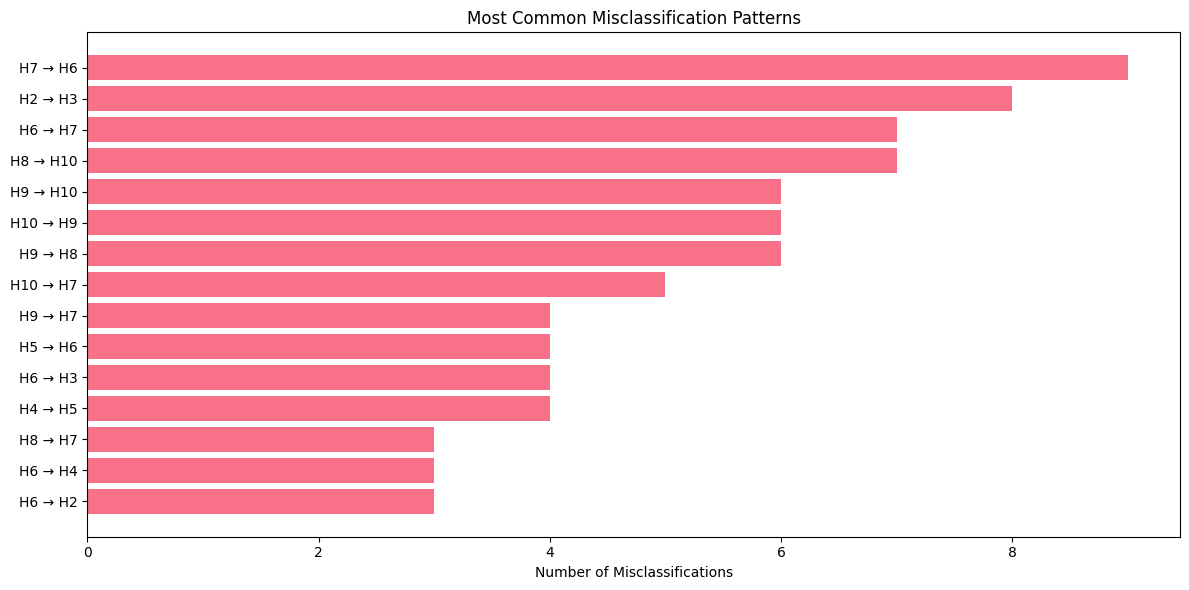


----------------------------------------------------------------------
DECISION CONFIDENCE ANALYSIS
----------------------------------------------------------------------

Decision confidence (mean absolute value):
  Correct classifications: 9.2973 ± 0.1174
  Misclassifications: 9.2069 ± 0.3010


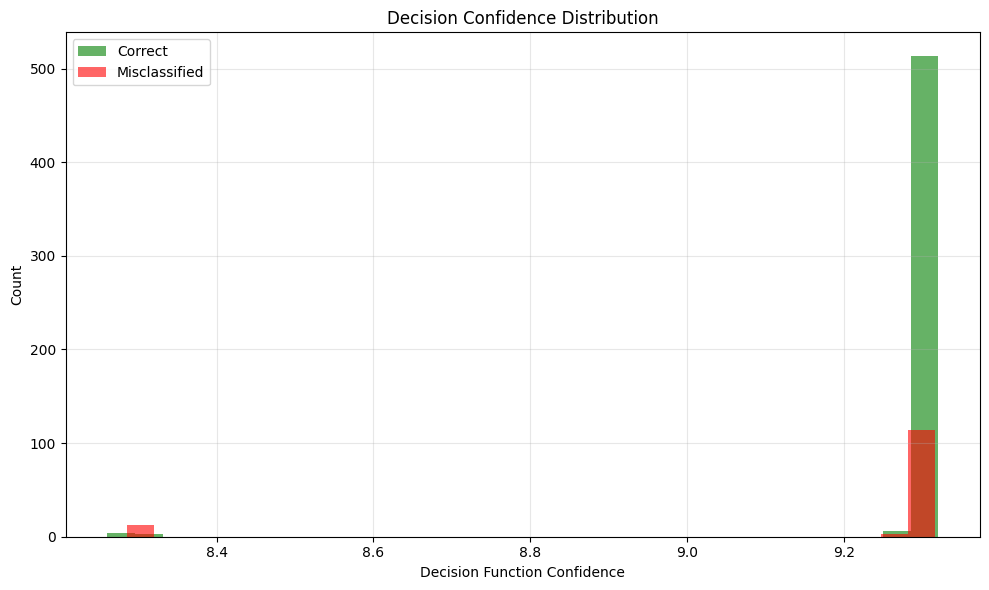


✓ Error analysis complete


In [ ]:
print("\n" + "="*70)
print("STEP 7: ERROR ANALYSIS")
print("="*70)

# Find misclassified samples
misclassified_mask = y_test != y_pred_final
misclassified_indices = np.where(misclassified_mask)[0]
n_misclassified = len(misclassified_indices)

print(f"\nMisclassified samples: {n_misclassified}/{len(y_test)} ({n_misclassified/len(y_test)*100:.2f}%)")

if n_misclassified > 0:
    # Analyze misclassification patterns
    print("\n" + "-"*70)
    print("MISCLASSIFICATION PATTERNS")
    print("-"*70)
    
    misclass_df = pd.DataFrame({
        'True': [species_names[y_test[i]] for i in misclassified_indices],
        'Predicted': [species_names[y_pred_final[i]] for i in misclassified_indices]
    })
    
    # Count confusion pairs
    confusion_pairs = misclass_df.groupby(['True', 'Predicted']).size().sort_values(ascending=False)
    
    print("\nMost common misclassifications:")
    for (true_class, pred_class), count in confusion_pairs.head(10).items():
        print(f"  {true_class} → {pred_class}: {count} times")
    
    # Visualize confusion pairs
    if len(confusion_pairs) > 0:
        plt.figure(figsize=(12, 6))
        top_confusions = confusion_pairs.head(15)
        labels = [f"{true_cls} → {pred_cls}" for (true_cls, pred_cls) in top_confusions.index]
        plt.barh(range(len(top_confusions)), top_confusions.values)
        plt.yticks(range(len(top_confusions)), labels)
        plt.xlabel('Number of Misclassifications')
        plt.title('Most Common Misclassification Patterns')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    # Decision confidence for misclassified samples
    if hasattr(best_svm, 'decision_function'):
        print("\n" + "-"*70)
        print("DECISION CONFIDENCE ANALYSIS")
        print("-"*70)
        
        # Get decision function values
        decision_values = best_svm.decision_function(X_test_scaled)
        
        # For correctly classified samples
        correct_mask = ~misclassified_mask
        if decision_values.ndim > 1:
            correct_confidence = np.max(decision_values[correct_mask], axis=1)
            misclass_confidence = np.max(decision_values[misclassified_mask], axis=1)
        else:
            correct_confidence = np.abs(decision_values[correct_mask])
            misclass_confidence = np.abs(decision_values[misclassified_mask])
        
        print(f"\nDecision confidence (mean absolute value):")
        print(f"  Correct classifications: {np.mean(correct_confidence):.4f} ± {np.std(correct_confidence):.4f}")
        print(f"  Misclassifications: {np.mean(misclass_confidence):.4f} ± {np.std(misclass_confidence):.4f}")
        
        # Visualize confidence distribution
        plt.figure(figsize=(10, 6))
        plt.hist(correct_confidence, bins=30, alpha=0.6, label='Correct', color='green')
        plt.hist(misclass_confidence, bins=30, alpha=0.6, label='Misclassified', color='red')
        plt.xlabel('Decision Function Confidence')
        plt.ylabel('Count')
        plt.title('Decision Confidence Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("\n✓ Perfect classification! No errors to analyze.")

print("\n✓ Error analysis complete")

## Step 8: Save Model and Generate Report

Save the trained model and generate a comprehensive summary report.

In [ ]:
print("\n" + "="*70)
print("STEP 8: SAVE MODEL AND GENERATE REPORT")
print("="*70)

# Define filenames for NCA models
if 'features_nca_10.csv' in features_file:
    suffix = 'nca10'
elif 'features_nca_2.csv' in features_file:
    suffix = 'nca2'
else:
    suffix = 'nca'

model_filename = f'../models/pola_{suffix}_svm_best.joblib'
scaler_filename = f'../models/pola_{suffix}_scaler.joblib'
label_encoder_filename = f'../models/pola_{suffix}_label_encoder.joblib'
summary_filename = f'../reports/pola_{suffix}_svm_summary.json'

joblib.dump(best_svm, model_filename)
joblib.dump(scaler_svm, scaler_filename)
joblib.dump(le, label_encoder_filename)

print(f"\nSaved model artifacts:")
print(f"  Model: {model_filename}")
print(f"  Scaler: {scaler_filename}")
print(f"  Label encoder: {label_encoder_filename}")

# Generate comprehensive summary report
summary_report = {
    'Model Type': f'Support Vector Machine (SVM) - {suffix.upper()}',
    'Best Kernel': best_svm.kernel,
    'Best Parameters': best_svm.get_params(),
    'Training Samples': len(X_train),
    'Test Samples': len(X_test),
    'Number of Features': X.shape[1],
    'Number of Classes': len(species_names),
    'Class Names': list(species_names),
    'Test Accuracy': f"{accuracy:.4f}",
    'Test Precision': f"{precision:.4f}",
    'Test Recall': f"{recall:.4f}",
    'Test F1-Score': f"{f1:.4f}",
    'CV Mean Accuracy': f"{cv_scores.mean():.4f}",
    'CV Std Accuracy': f"{cv_scores.std():.4f}",
    'Number of Support Vectors': len(best_svm.support_),
    'Support Vector Ratio': f"{len(best_svm.support_) / len(X_train_scaled):.2%}",
}

# Save summary to JSON
with open(summary_filename, 'w') as f:
    json.dump(summary_report, f, indent=2, default=str)

print(f"\nSaved model summary: {summary_filename}")

# Print final summary
print("\n" + "="*70)
print("SVM CLASSIFICATION PIPELINE - FINAL SUMMARY")
print("="*70)

print(f"\n{'Model Configuration:':<30}")
print(f"  {'Kernel:':<28} {best_svm.kernel}")
if best_svm.kernel in ['rbf', 'poly']:
    print(f"  {'C parameter:':<28} {best_svm.C}")
    print(f"  {'Gamma:':<28} {best_svm.gamma}")
if best_svm.kernel == 'poly':
    print(f"  {'Degree:':<28} {best_svm.degree}")
elif best_svm.kernel == 'linear':
    print(f"  {'C parameter:':<28} {best_svm.C}")

print(f"\n{'Dataset Information:':<30}")
print(f"  {'Total samples:':<28} {len(X)}")
print(f"  {'Training samples:':<28} {len(X_train)}")
print(f"  {'Test samples:':<28} {len(X_test)}")
print(f"  {'Number of features:':<28} {X.shape[1]}")
print(f"  {'Number of species:':<28} {len(species_names)}")

print(f"\n{'Performance Metrics:':<30}")
print(f"  {'Test Accuracy:':<28} {accuracy:.4f}")
print(f"  {'Test Precision:':<28} {precision:.4f}")
print(f"  {'Test Recall:':<28} {recall:.4f}")
print(f"  {'Test F1-Score:':<28} {f1:.4f}")
print(f"  {'CV Accuracy (10-fold):':<28} {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

print(f"\n{'Model Characteristics:':<30}")
print(f"  {'Support vectors:':<28} {len(best_svm.support_)}")
print(f"  {'Support vector ratio:':<28} {len(best_svm.support_) / len(X_train_scaled):.2%}")
print(f"  {'Misclassified (test):':<28} {n_misclassified}/{len(y_test)} ({n_misclassified/len(y_test)*100:.2f}%)")

print(f"\n{'Output Files:':<30}")
print(f"  • {model_filename}")
print(f"  • {scaler_filename}")
print(f"  • {label_encoder_filename}")
print(f"  • {summary_filename}")

print("\n" + "="*70)
print("✓ SVM CLASSIFICATION PIPELINE COMPLETE")
print("="*70)

print("\nThe trained SVM model is ready. You can switch to use different features by changing USE_NCA_9/USE_NCA_10 flags at Step 1.")


STEP 8: SAVE MODEL AND GENERATE REPORT

Saved model artifacts:
  Model: ../models/pola_nca10_svm_best.joblib
  Scaler: ../models/pola_nca10_scaler.joblib
  Label encoder: ../models/pola_nca10_label_encoder.joblib

Saved model summary: ../reports/pola_nca10_svm_summary.json

SVM CLASSIFICATION PIPELINE - FINAL SUMMARY

Model Configuration:          
  Kernel:                      rbf
  C parameter:                 10
  Gamma:                       scale

Dataset Information:          
  Total samples:               3277
  Training samples:            2621
  Test samples:                656
  Number of features:          10
  Number of species:           10

Performance Metrics:          
  Test Accuracy:               0.8018
  Test Precision:              0.8024
  Test Recall:                 0.8018
  Test F1-Score:               0.8004
  CV Accuracy (10-fold):       0.7871 ± 0.0193

Model Characteristics:        
  Support vectors:             1729
  Support vector ratio:        65.97

## Step 9: Supplementary - NCA2 Analysis

Automatically process and generate a summary for the 2-dimensional NCA features (NCA2).

In [ ]:
print("\n" + "="*70)
print("STEP 9: SUPPLEMENTARY NCA2 ANALYSIS")
print("="*70)

nca2_file = '../data/features_nca_2.csv'

if os.path.exists(nca2_file):
    print(f"Processing {nca2_file}...")

    # 1. Load Data
    df_2 = pd.read_csv(nca2_file)
    print(f"Datasets Loaded: {df_2.shape}")

    # 2. Extract Features & Targets
    feat_cols_2 = [c for c in df_2.columns if c.startswith('nca')]
    X_2 = df_2[feat_cols_2].values

    if 'label' in df_2.columns:
        y_raw_2 = df_2['label'].values
    elif 'label_code' in df_2.columns:
        y_raw_2 = df_2['label_code'].values
    else:
        y_raw_2 = df_2['filename'].astype(str).str.extract(r'(?i)(h\d+)')[0].str.upper().fillna('UNKNOWN').values

    le_2 = LabelEncoder()
    y_enc_2 = le_2.fit_transform(y_raw_2)

    # 3. Split & Scale
    X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
        X_2, y_enc_2, test_size=0.2, random_state=42, stratify=y_enc_2
    )
    scaler_2 = StandardScaler()
    X_train_s2 = scaler_2.fit_transform(X_train_2)
    X_test_s2 = scaler_2.transform(X_test_2)

    # 4. Train Model (Using Linear SVM for this quick summary, or reusing known best params)
    # We'll do a quick loop like baseline to pick best
    best_acc = 0
    best_m = None
    best_k = ''

    print("\nTraining models for NCA2:")
    for k in ['linear', 'rbf', 'poly']:
        m = SVC(kernel=k, random_state=42)
        m.fit(X_train_s2, y_train_2)
        acc = accuracy_score(y_test_2, m.predict(X_test_s2))
        print(f"  {k.upper()}: Accuracy={acc:.4f}")
        if acc > best_acc:
            best_acc = acc
            best_m = m
            best_k = k

    print(f"\nBest NCA2 model: {best_k.upper()} (Accuracy: {best_acc:.4f})")

    # 5. Save Artifacts
    prefix = 'pola_nca2'
    joblib.dump(best_m, f'../models/{prefix}_svm_best.joblib')
    joblib.dump(scaler_2, f'../models/{prefix}_scaler.joblib')
    joblib.dump(le_2, f'../models/{prefix}_label_encoder.joblib')

    # 6. Save Summary JSON
    y_pred_2 = best_m.predict(X_test_s2)
    summ_2 = {
        'Model Type': f'Support Vector Machine (SVM) - NCA2',
        'Best Kernel': best_k,
        'Test Accuracy': f"{best_acc:.4f}",
        'Test Precision': f"{precision_score(y_test_2, y_pred_2, average='weighted', zero_division=0):.4f}",
        'Test Recall': f"{recall_score(y_test_2, y_pred_2, average='weighted', zero_division=0):.4f}",
        'Test F1-Score': f"{f1_score(y_test_2, y_pred_2, average='weighted', zero_division=0):.4f}"
    }
    with open(f'../reports/{prefix}_svm_summary.json', 'w') as f:
        json.dump(summ_2, f, indent=2)

    print(f"\nSaved NCA2 summary to {prefix}_svm_summary.json")
    print(json.dumps(summ_2, indent=2))

else:
    print("\nfeatures_nca_2.csv not found. Skipping supplementary analysis.")



STEP 9: SUPPLEMENTARY NCA2 ANALYSIS
Processing ../data/features_nca_2.csv...
Datasets Loaded: (3277, 4)

Training models for NCA2:
  LINEAR: Accuracy=0.2744
  RBF: Accuracy=0.4558
  POLY: Accuracy=0.3354

Best NCA2 model: RBF (Accuracy: 0.4558)

Saved NCA2 summary to pola_nca2_svm_summary.json
{
  "Model Type": "Support Vector Machine (SVM) - NCA2",
  "Best Kernel": "rbf",
  "Test Accuracy": "0.4558",
  "Test Precision": "0.5283",
  "Test Recall": "0.4558",
  "Test F1-Score": "0.4516"
}
